In [1]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import cv2 
import os
import random

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torch.utils.data import DataLoader, Dataset
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import PIL

# 기본 함수

In [2]:
def get_img_label(index,img_size,coco,data_dir):
    """ 각각의 이미지 마다 이미지와 meta정보를 가져옴
    """
    image_id = coco.getImgIds(imgIds=index)

    image_info = coco.loadImgs(image_id)[0]

    image = cv2.imread(os.path.join(data_dir, image_info['file_name']))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0

    ann_ids = coco.getAnnIds(imgIds=image_info['id'])
    anns = coco.loadAnns(ann_ids)

    boxes = np.array([x['bbox'] for x in anns])

    # boxex (x_min, y_min, x_max, y_max)
    boxes[:, 2] = (boxes[:, 0] + boxes[:, 2]) * img_size/ image.shape[1]
    boxes[:, 3] = (boxes[:, 1] + boxes[:, 3]) * img_size / image.shape[0]
    boxes[:, 0] = boxes[:, 0] * img_size / image.shape[1]
    boxes[:, 1] = boxes[:, 1] * img_size / image.shape[0]

    labels = [x['category_id'] for x in anns]
    areas = [x['area'] for x in anns]

    insert_seg = []
    for x in anns:
        insert_seg.append(x['segmentation'])

    segments = insert_seg

    image = cv2.resize(image, (img_size, img_size))

    return image, labels, boxes, segments, areas

In [3]:
def load_mosaic(index, img_size, coco, data_dir, data_count, upsampling_mode, sampling_list):
    """모자이크 이미지와 메타 정보 생성
    """
    # loads images in a 4-mosaic
    boxes4 = []
    labels4 = []
    segs4 = []
    areas4 = []
    s = img_size
    h = s
    w = s
    
    xc,yc  = 512,512
    if not upsampling_mode:
        indices = [index, index + 1, index +2, index + 3]
    else:
        pick_ids = [sampling_list[random.randint(0,len(sampling_list) -1)] for _ in range(3)]
        indices = [index] + pick_ids
    
    for i, index in enumerate(indices):   
        # Load image
        img, original_label, original_boxes, original_segs, original_areas = \
        get_img_label(index, img_size, coco, data_dir ) # image, label, boxes, segments(이미지 인덱스에 있는거 뽑아오기)
            
        # place img in img4
        if i == 0:  # top left
            img4 = np.full((s * 2, s * 2, img.shape[2]), 114/ 255.0, dtype=np.float32)  # base image with 4 tiles
            x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
        elif i == 1:  # top right
            x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
            x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
        elif i == 2:  # bottom left
            x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, w, min(y2a - y1a, h)
        elif i == 3:  # bottom right
            x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

        img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
        padw = x1a - x1b
        padh = y1a - y1b
        
        labels = original_label.copy()
        boxes = original_boxes.copy()
        areas = original_areas.copy()
        
        for original_seg1 in original_segs: # 어노테이션별 접근
            original_seg1 = np.array(original_seg1)
            for original_seg2 in original_seg1: #segmentation별 접근
                original_seg2 = np.array(original_seg2)
                assert len(original_seg2[0::2]) == len(original_seg2[1::2])
                
        segs = original_segs.copy()
            
        if len(labels) > 0:
            boxes[:, 0] = (original_boxes[:, 0]) + padw
            boxes[:, 1] = (original_boxes[:, 1]) + padh
            boxes[:, 2] = (original_boxes[:, 2]) + padw
            boxes[:, 3] = (original_boxes[:, 3]) + padh
            
            for i in range(len(original_segs)): # 어노테이션별 접근
                original_segs[i] = np.array(original_segs[i])
                for j in range(len(original_segs[i])): #box하나당 segmentation별 접근
                    original_segs[i][j] = np.array(original_segs[i][j])
                    
                    segs[i][j][0::2] = (original_segs[i][j][0::2]) + padw
                    segs[i][j][1::2] = (original_segs[i][j][1::2]) + padh
            
            
        boxes4.append(boxes)
        labels4.append(labels)
        segs4.append(segs)
        areas4.append(areas)
    
    # segs4 concatenate
    segs_concatenate = []
    for seg4 in segs4:
        seg4 = list(seg4)
        for seg4_annotation in seg4:
            seg4_annotation = list(seg4_annotation)
            segs_concatenate.append(seg4_annotation)
    
    labels4 = np.concatenate(labels4, 0)
    boxes4 = np.concatenate(boxes4, 0)
    segs4 = segs_concatenate
    areas4 = np.concatenate(areas4, 0)
    
#     np.clip(boxes4, 0, 2 * s, out=boxes4)
    
#     indicies  = []
    
#     for i, box in enumerate(boxes4):
#         if box[0] >= box[2] or box[1] >= box[3]:
#             indicies.append(i)
    
#     boxes4 = np.delete(boxes4, indicies, axis = 0)
#     labels4 = np.delete(labels4, indicies, axis = 0)
    
    return img4, labels4, boxes4, segs4, areas4

In [4]:
def get_mosaic_image(coco,annotation,data_dir,img_size,index : int, data_count, upsampling_mode, sampling_list):
    """image id에 해당하는 변형된 데이터 가져오기
    """
    image_id = coco.getImgIds(imgIds=index)
    
    image_info = coco.loadImgs(image_id)[0]
    
    image, labels, boxes, segs, areas = load_mosaic(index, img_size,coco, data_dir, data_count, upsampling_mode, sampling_list)
    
#     labels = torch.as_tensor(labels, dtype = torch.int64)
    
    image = torch.tensor(image)
#     boxes = torch.tensor(boxes, dtype=torch.float32)
    
    return image, labels, boxes, segs, areas
    

In [5]:
coco = COCO('/opt/ml/input/data/train.json')
data_count = coco.getImgIds()
print(len(data_count))

loading annotations into memory...
Done (t=3.33s)
creating index...
index created!
2617


# COCO데이터셋 생성

In [6]:
annotation = '/opt/ml/input/data/train.json'
data_dir = '/opt/ml/input/data'
img_size = 512

mosaic_images = []
mosaic_labels = []
mosaic_boxes = []
mosaic_segments = []
mosaic_areas = []

coco = COCO(annotation)

for idx in tqdm(range(0, 2616, 4)):
    image , labels, boxes, segments, areas = get_mosaic_image(coco,
                                                              annotation,
                                                              data_dir, 
                                                              img_size,idx, 
                                                              data_count, 
                                                              False,
                                                              None
                                                             )
    mosaic_images.append(image)
    mosaic_labels.append(labels)
    mosaic_boxes.append(boxes)
    mosaic_segments.append(segments)
    mosaic_areas.append(areas)

zero_class_image_id = []
# 0번 클래스를 가지는 이미지 아이디 가져오기
for idx in range(0, 2617):
    ann_ids = coco.getAnnIds(imgIds =idx)
    anns = coco.loadAnns(ann_ids)
    
    flag = False
    for ann in anns:
        category_id = ann['category_id']
        if category_id == 0:
            flag = True
            break
    if flag:
        zero_class_image_id.append(idx)
    
for i in range(2):
    for idx in tqdm(zero_class_image_id):
        image , labels, boxes, segments, areas = get_mosaic_image(coco,
                                                              annotation,
                                                              data_dir, 
                                                              img_size,idx, 
                                                              data_count, 
                                                              True,
                                                              zero_class_image_id
                                                             )
        mosaic_images.append(image)
        mosaic_labels.append(labels)
        mosaic_boxes.append(boxes)
        mosaic_segments.append(segments)
        mosaic_areas.append(areas)
    

loading annotations into memory...
Done (t=3.65s)
creating index...
index created!


100%|██████████| 88/88 [00:05<00:00, 16.74it/s]


In [7]:
for i in range(len(mosaic_labels)):
    mosaic_labels[i] = mosaic_labels[i].tolist()

In [8]:
type(mosaic_labels[1])

list

In [9]:
print(type(mosaic_labels[0]))

<class 'list'>


In [10]:
for i in range(len(mosaic_boxes)):
    mosaic_boxes[i] = mosaic_boxes[i].tolist()

In [11]:
for i in range(len(mosaic_boxes)):
    mosaic_areas[i] = mosaic_areas[i].tolist()

In [12]:
for i in range(len(mosaic_segments)):
    for j in range(len(mosaic_segments[i])):
        for k in range(len(mosaic_segments[i][j])):
            for l in range(len(mosaic_segments[i][j][k])):
                mosaic_segments[i][j][k][l] = int(mosaic_segments[i][j][k][l])

In [14]:
from torchvision.utils import save_image
import torch
import torchvision

# 이미지 저장
for i in tqdm(range(len(mosaic_images))):
    storage_image = mosaic_images[i]
    storage_image = mosaic_images[i].permute([2,0,1])
    image_name = '{0:04d}'.format(i)
    save_image(storage_image, '/opt/ml/input/data/mosaic_upsample_class1/' + image_name + '.jpg')

100%|██████████| 830/830 [00:36<00:00, 22.61it/s]


In [15]:
# coco dataformat으로 변경
import json

with open("/opt/ml/input/data/train.json") as json_file:
    json_data = json.load(json_file)


In [16]:
json_data['info'] # 그대로

{'year': 2021,
 'version': '1.0',
 'description': 'Recycle Trash',
 'contributor': 'Upstage',
 'url': None,
 'date_created': '2021-02-02 01:10:00'}

In [17]:
json_data['licenses'] # 그대로

[{'id': 0,
  'name': 'CC BY 4.0',
  'url': 'https://creativecommons.org/licenses/by/4.0/deed.ast'}]

In [18]:
json_data['categories'] # 그대로

[{'id': 0, 'name': 'UNKNOWN', 'supercategory': 'UNKNOWN'},
 {'id': 1, 'name': 'General trash', 'supercategory': 'General trash'},
 {'id': 2, 'name': 'Paper', 'supercategory': 'Paper'},
 {'id': 3, 'name': 'Paper pack', 'supercategory': 'Paper pack'},
 {'id': 4, 'name': 'Metal', 'supercategory': 'Metal'},
 {'id': 5, 'name': 'Glass', 'supercategory': 'Glass'},
 {'id': 6, 'name': 'Plastic', 'supercategory': 'Plastic'},
 {'id': 7, 'name': 'Styrofoam', 'supercategory': 'Styrofoam'},
 {'id': 8, 'name': 'Plastic bag', 'supercategory': 'Plastic bag'},
 {'id': 9, 'name': 'Battery', 'supercategory': 'Battery'},
 {'id': 10, 'name': 'Clothing', 'supercategory': 'Clothing'}]

In [19]:
len(json_data['images'])

2617

In [20]:
json_data['images'][2616]

{'license': 0,
 'url': None,
 'file_name': 'batch_03/1000.jpg',
 'height': 512,
 'width': 512,
 'date_captured': None,
 'id': 2616}

In [21]:
# 이미지 정보 넣기
for i in tqdm(range(len(mosaic_images))):
    insert_dict = {}
    insert_dict['license'] = 0
    insert_dict['url'] = None
    insert_dict['file_name'] = 'mosaic_upsample_class1/' +  '{0:04d}'.format(i) + ".jpg"
    insert_dict["height"] = 1024
    insert_dict["width"] = 1024
    insert_dict["data_captured"] = None
    insert_dict["id"] = 2617 + i
    
    json_data["images"].append(insert_dict)

100%|██████████| 830/830 [00:00<00:00, 318506.16it/s]


In [22]:
len(json_data['annotations'])

21116

In [23]:
# json_data['annotations'][26399]

In [24]:
ann_id = 0

for i in tqdm(range(len(mosaic_images))):
    for j in range(len(mosaic_labels[i])):
        insert_dict = {}
        insert_dict["id"] = 21116 + ann_id
        insert_dict["image_id"] = 2617 + i
        insert_dict["category_id"] = mosaic_labels[i][j]
        insert_dict["segmentation"] = mosaic_segments[i][j]
        insert_dict["area"] = mosaic_areas[i][j]
        box_format = [mosaic_boxes[i][j][0], mosaic_boxes[i][j][1], mosaic_boxes[i][j][2] - mosaic_boxes[i][j][0], mosaic_boxes[i][j][3] - mosaic_boxes[i][j][1]]
        
        insert_dict["bbox"] = box_format
        insert_dict["iscrowd"] = 0
        ann_id += 1
        json_data['annotations'].append(insert_dict)

100%|██████████| 830/830 [00:00<00:00, 1231.42it/s]


In [25]:
obj1 = json.dumps(json_data)
# print(type(obj1))
# obj1

In [26]:
with open('/opt/ml/input/data/train_mosaic_upsampling.json', 'w') as f:
    json.dump(json_data,f)

## 시각화

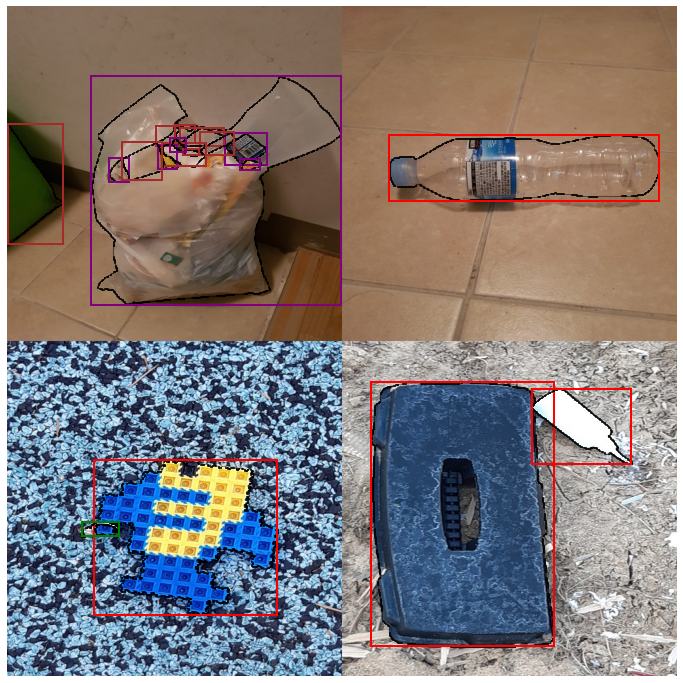

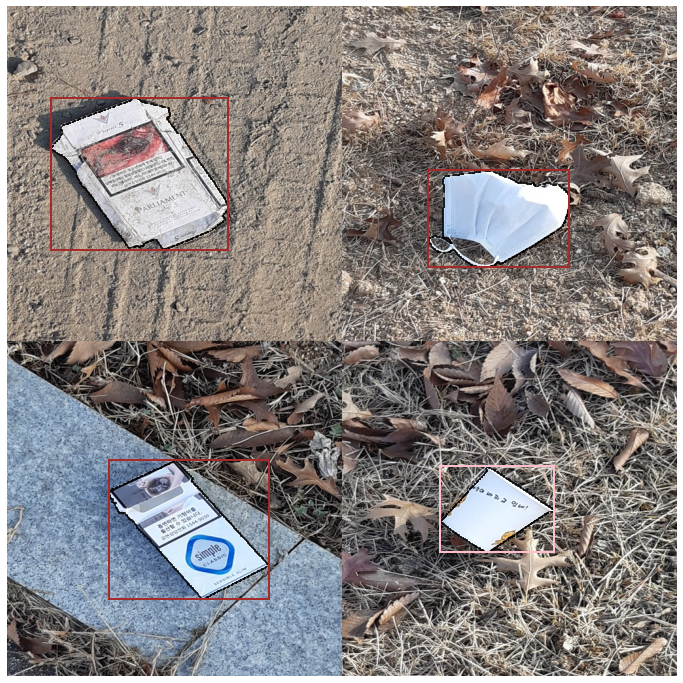

In [96]:
for i in range(len(mosaic_images)):
    image = mosaic_images[i]
    labels = mosaic_labels[i]
    boxes = mosaic_boxes[i]
    segments = mosaic_segments[i]
    
    plt.figure(figsize=(12,17))
    plt.axis('off')

    plt.imshow(image)

    edge_colors = ['blue', 'brown', 'orange', 'pink', 'green',
                  'gray', 'red', 'olive', 'purple', 'cyan',
                   'black', 'seagreen'
                  ]

    ax = plt.gca()

    for i in range(len(labels)):
        class_label = labels[i]
        boxes_info = boxes[i]
        seg_info = segments[i]

        for seg_info_location in seg_info:
            for i in range(0,len(seg_info_location),2):
                x = seg_info_location[i]
                y = seg_info_location[i+1]

                rect = patches.Rectangle(
                    (x, y), 1, 1,
                    edgecolor='black',
                    facecolor='black',
                    linewidth=0.5,
                    fill=True
                )

                ax.add_patch(rect)


        rect = patches.Rectangle((boxes_info[0],boxes_info[1]),
                             boxes_info[2] - boxes_info[0],
                             boxes_info[3] - boxes_info[1],
                             linewidth=2,
                             edgecolor=edge_colors[class_label],
                             fill = False)

        ax.add_patch(rect)

    plt.show()